### RDD to estimate the effect of the reopening of schools on 31/8/2020 in Quebec: ###
#### by: Mahmoud El Hazzouri ####

### Libraries Imported ###

In [1]:
### Linear Algebra 
import numpy as np 

### Data Processing 
import pandas as pd 

### Data Visualization 
import seaborn as sns

### Matplotlib inline
from matplotlib import pyplot as plt

### Algorithims 
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

### Acquiring and Imporing the dataset ###

In [2]:
CovidQubec = pd.read_csv('Quebec_2020.csv')
CovidQubec.head()

,region,date,daily_cases,daily_death,daily_hospitalization,daily_ICU,daily_test_completed
0,QC,2020-01-23,0,0,0,0,2
1,QC,2020-01-24,0,0,0,0,0
2,QC,2020-01-25,0,0,0,0,0
3,QC,2020-01-26,0,0,0,0,0
4,QC,2020-01-27,0,0,0,0,1


### Summary Statistics ###

In [3]:
print ("==============================================================================")
print ("                              OVERALL SUMMARY")
print ("==============================================================================")
print (CovidQubec.describe())

                              OVERALL SUMMARY
       daily_cases  daily_death  daily_hospitalization   daily_ICU  \
count   375.000000   375.000000             375.000000  375.000000   
mean    678.794667    26.602667               3.029333    0.509333   
std     703.982976    32.182210              48.715552    8.996987   
min       0.000000     0.000000            -235.000000  -19.000000   
25%     100.000000     2.000000              -8.000000   -2.000000   
50%     501.000000    13.000000               0.000000    0.000000   
75%    1068.500000    42.000000               9.000000    2.000000   
max    3100.000000   153.000000             758.000000  146.000000   

       daily_test_completed  
count            375.000000  
mean           14938.517333  
std            11123.377400  
min                0.000000  
25%             6200.500000  
50%            12167.000000  
75%            24802.000000  
max            39419.000000  


### Defining the time period we are going to do RDD over in order to estimate the effect of the August Reopening ~ July 31 - September 28 ###

In [4]:
df = CovidQubec[190:250]

In [5]:
df.head()

,region,date,daily_cases,daily_death,daily_hospitalization,daily_ICU,daily_test_completed
190,QC,2020-07-31,160,4,-19,-3,16154
191,QC,2020-08-01,122,1,-12,3,14849
192,QC,2020-08-02,123,2,-5,-1,10205
193,QC,2020-08-03,102,2,0,1,11777
194,QC,2020-08-04,140,0,-3,3,16246


In [6]:
### Time period we are doing RDD over: 60 Days
len(df)

60

In [7]:
df.head()

,region,date,daily_cases,daily_death,daily_hospitalization,daily_ICU,daily_test_completed
190,QC,2020-07-31,160,4,-19,-3,16154
191,QC,2020-08-01,122,1,-12,3,14849
192,QC,2020-08-02,123,2,-5,-1,10205
193,QC,2020-08-03,102,2,0,1,11777
194,QC,2020-08-04,140,0,-3,3,16246


In [8]:
df.tail()

,region,date,daily_cases,daily_death,daily_hospitalization,daily_ICU,daily_test_completed
245,QC,2020-09-24,658,4,9,1,30211
246,QC,2020-09-25,737,6,15,2,28622
247,QC,2020-09-26,787,2,18,12,26585
248,QC,2020-09-27,876,7,-4,-4,22780
249,QC,2020-09-28,921,4,-5,-4,24637


### Visualizing the change in Covid Cases between July 31 and September 28 ###

In [9]:
x = pd.to_datetime(df['date'])
y = df['daily_cases']

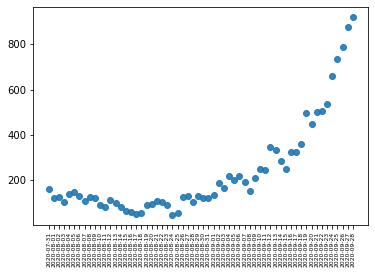

In [10]:
plt.scatter(x, y, alpha = 0.9)
plt.xticks(x, rotation = 'vertical', size = 6)
plt.show()

### Set up Forcing Variable and Cutoff Predictor ###

In [11]:
Threshold = df['date'] > '2020-08-31'

In [12]:
rdd_df = df.assign(Threshold = df['date']> '2020-08-31')

In [13]:
rdd_df.iloc[:,-1] = encoder.fit_transform(rdd_df.iloc[:,-1].values)

### Encoding the dates as well for easier visualization on the x-axis ###

In [14]:
rdd_df.iloc[:,1] = encoder.fit_transform(rdd_df.iloc[:,1].values)
rdd_df['date'].head()

190    0
191    1
192    2
193    3
194    4
Name: date, dtype: int64

In [15]:
rdd_df.head()

,region,date,daily_cases,daily_death,daily_hospitalization,daily_ICU,daily_test_completed,Threshold
190,QC,0,160,4,-19,-3,16154,0
191,QC,1,122,1,-12,3,14849,0
192,QC,2,123,2,-5,-1,10205,0
193,QC,3,102,2,0,1,11777,0
194,QC,4,140,0,-3,3,16246,0


### RDD Estimation: Method 1 ###

In [16]:
model = smf.wls('daily_cases~date*Threshold', rdd_df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,117.2443,23.113,5.073,0.000,70.943,163.546
date,-0.9573,1.281,-0.747,0.458,-3.524,1.609
Threshold,-881.6688,75.945,-11.609,0.000,-1033.804,-729.534
date:Threshold,26.2767,2.023,12.990,0.000,22.224,30.329


### RDD Estimation: Method 2 ###

In [17]:
window = rdd_df[(rdd_df['date']>=0) & (rdd_df['date']<=60)]
result = smf.ols(formula = "daily_cases ~ date *Threshold", 
                 data = window).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            daily_cases   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     177.8
Date:                Mon, 24 Oct 2022   Prob (F-statistic):           1.37e-28
Time:                        09:47:51   Log-Likelihood:                -335.27
No. Observations:                  60   AIC:                             678.5
Df Residuals:                      56   BIC:                             686.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        117.2443     23.113      5.073      0.000      70.943     163.546
date              -0.9573      1.281     -0.747      0.458      -3.524       1.609
Threshold       -881.6688     75.945    -11.609      0.000   -1033.804    -729.534
date:Threshold    26.2767      2.023     12.990      0.000      22.224      30.329
==============================================================================
Omnibus:                        4.420   Durbin-Watson:                   0.359
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                3.588
Skew:                           0.420   Prob(JB):                        0.166
Kurtosis:                       3.854   Cond. No.                         403.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### RDD Plot ###

Text(0.5, 1.0, 'Regression Discontinuity')

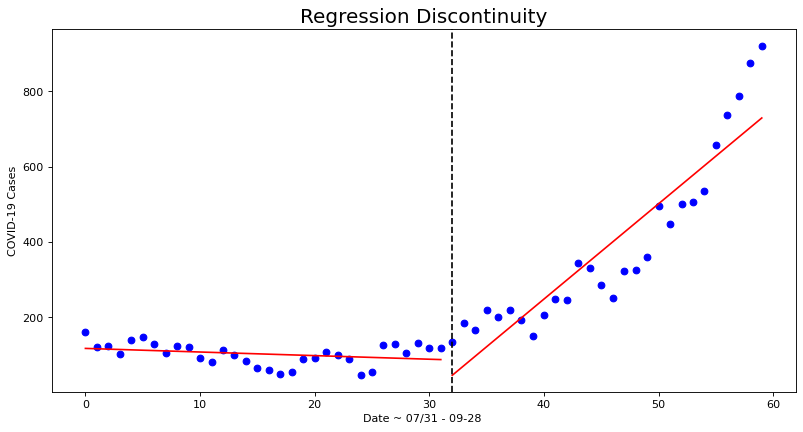

In [18]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(window.date,window.daily_cases, color="blue")
l=window[window.date<32].date.count() ### Index 32 corresponds to 08/31/2020
plt.plot(window.date[0:l], model.predict()[0:l], '-', color="r")
plt.plot(window.date[l:], model.predict()[l:], '-', color="r")
plt.xlabel('Date ~ 07/31 - 09-28 ')
plt.ylabel('COVID-19 Cases')
plt.axvline(x=32,color="black", linestyle="--")
plt.title("Regression Discontinuity", fontsize="18")

### Conclusion ###

This Model is telling us that the the reopining of 08-31-2020 increases the number of COVID-19 cases. Also, we see a statistically significant effect of reopening on reading scores (p<0.05), as expressed in the coeficient Threshold. 

We also verified the model visually, by showing the predicted values on the data we have. We have to regression models: one before 08/31 and one after. The plots verify the RDD model. 